<a href="https://colab.research.google.com/github/safanisna/datascientest-ocr/blob/main/DataScientest_Safan_Doc_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets
!pip install opencv-python
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import image as mpimg

Downloading datasets from kaggle using opendatasets (need kaggle account to provide kaggle credentials)

In [6]:
od.download('https://www.kaggle.com/datasets/manishthem/text-extraction-for-ocr')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: safanisna
Your Kaggle Key: ··········


100%|██████████| 34.1M/34.1M [00:00<00:00, 117MB/s] 


# Datasets
Below are the given description regarding the dataset.

> ### About Dataset
> #### Context
Typical NER will identify various entities in the text but not every name come with proper context. The data set provides structured data in the XML format and requires its users to extract various entities.
> #### Content
The data set consist of XML files and images. The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. Users of the dataset should extract entities like invoice no, invoice data, company name (invoice from company1 to company2/person), telephone number of the company, address e.t.c
> #### Acknowledgements
We wouldn't be here without the help of others. If you owe any attributions or thanks, include them here along with any citations of past research.
> #### Inspiration
Challenges: <br>
Invoices data contains tabular data, which is challenging to deal with. Design a methodology to extract information from tabular data.
Due to obvious reasons, certain numbers in XML are erroneous for eg, '0' replaced by 'O'.

## Understanding the Data
Find dataset using `os` package to see the completeness of datasets.

In [7]:
import os
path_ = '/content/text-extraction-for-ocr/ImageAndXML_Data'

In [8]:
# dataset path

dtph = '/'
filepath = path_ + dtph

### Completeness checking
To check whether we have all the neccessary files

In [9]:
# counting number of files inside the dataset
# counting the completeness of each image file

nfiles = 0

# Initializing filename, gt, ocr file as a checklist

tifs, gts, ocrs, oths = [], [], [], []


for i, file in enumerate(os.listdir(filepath)):
    nfiles += 1
    if i < 10:
        print(os.path.join(dtph, file))
    if file.endswith('.tif'):
        tifs.append(file)
    elif file.endswith('_gt.xml'):
        gts.append(file)
    elif file.endswith('_ocr.xml'):
        ocrs.append(file)
    else:
        oths.append(file)

print('\n')
print('There are total', nfiles, 'number of files in the data')

/2037023778_gt.xml
/2073684342_gt.xml
/00920343.tif
/11237693_11237694.tif
/0011899826_gt.xml
/2072957830.tif
/83565599_gt.xml
/0011500947_ocr.xml
/500234635+-4635_ocr.xml
/92173709_gt.xml


There are total 1560 number of files in the data


If we look at the filename above. All filename are assumed to be formatted this way:
1. xx.tif as the image
2. xx_gt.xml as the 1st xml
3. xx_ocr.xml as the 2nd xml

The xx will then called as `image_id`

Referring to the description: <br> <b> The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. </b>

In [10]:
print('#file formatted .tif:', len(tifs))
print('#file formatted _gt.xml:', len(gts))
print('#file formatted _ocr.xml:', len(ocrs))

#file formatted .tif: 520
#file formatted _gt.xml: 520
#file formatted _ocr.xml: 520


In [11]:
all_files = tifs + gts + ocrs
ids = [i.replace('.tif', '').replace('_gt.xml','').replace('_ocr.xml','') for i in all_files]
ids = list(set(ids))

print('#image id:', len(ids))

#image id: 520


In [12]:
# file completeness check

a = [0] * len(ids)
tifs_ = a.copy()
gts_ = a.copy()
ocrs_ = a.copy()

for i,id_ in enumerate(ids):
    _tif = str(id_) + '.tif'
    _gt = str(id_) + '_gt.xml'
    _ocr = str(id_) + '_ocr.xml'
    if i < 10:
        if _tif in tifs:
            tifs_[i] = 1
        if _gt in gts:
            gts_[i] = 1
        if _ocr in ocrs:
            ocrs_[i] = 1

In [13]:
ids, tifs, gts, ocrs = sorted(ids), sorted(tifs), sorted(gts), sorted(ocrs)

df1 = pd.DataFrame({'id': ids, '.tif':tifs, '_gt.xml':gts, '_ocr.xml':ocrs})
df1.tail()

,id,.tif,_gt.xml,_ocr.xml
515,ti17120992,ti17120992.tif,ti17120992_gt.xml,ti17120992_ocr.xml
516,ti31149327_9330,ti31149327_9330.tif,ti31149327_9330_gt.xml,ti31149327_9330_ocr.xml
517,ti31689113,ti31689113.tif,ti31689113_gt.xml,ti31689113_ocr.xml
518,ti31689150,ti31689150.tif,ti31689150_gt.xml,ti31689150_ocr.xml
519,tob02910.64,tob02910.64.tif,tob02910.64_gt.xml,tob02910.64_ocr.xml


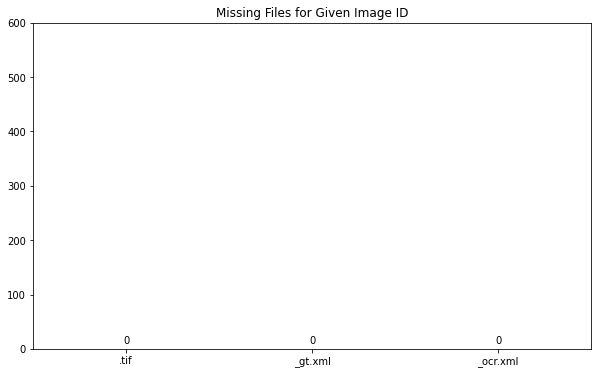

In [14]:
nrow = df1.shape[0]
ct = df1.isna().sum()[1:]

f, ax = plt.subplots(1,1, figsize=(10, 6))
ct.plot(kind='bar', ax=ax)
ax.set_ylim([0, 600])
ax.set_xticklabels(ct.index, rotation = 0)
ax.set_title('Missing Files for Given Image ID')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
# f, ax = plt.gcf(), plt.

<b> From the dataframe above, it's safe to conclude that each image_id has `.tif`, `_gt.xml`, and `_ocr.xml` files. </b>

### What is the data look like?
See what we are dealing with in this document extraction dataset

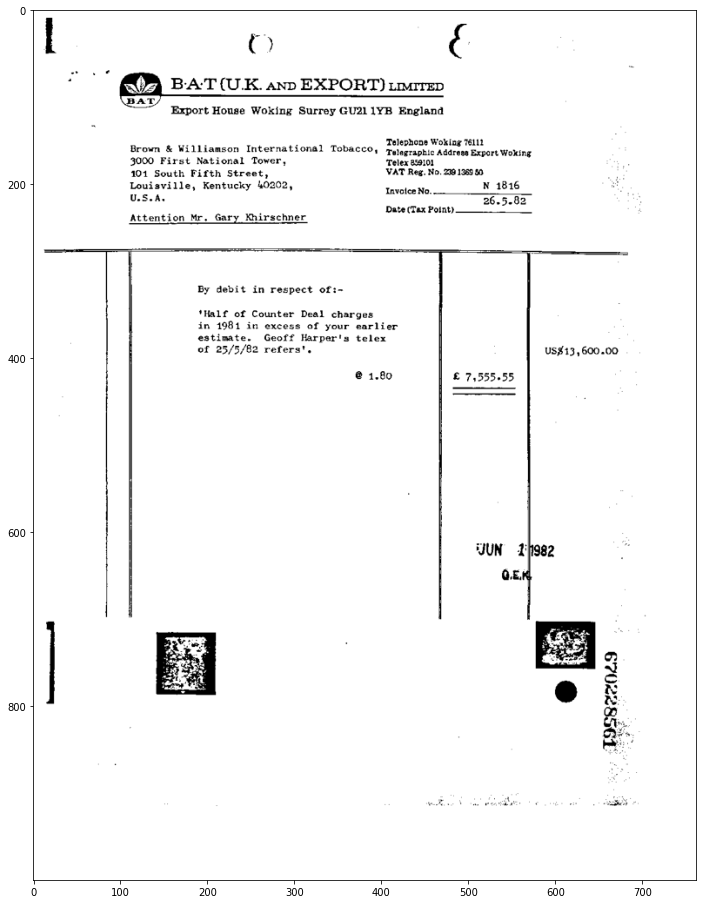

In [15]:
fn = '0000223278.tif'
fn = filepath + fn
image = mpimg.imread(fn)
plt.imshow(image, cmap='gray')
f = plt.gcf()
f.set_size_inches(24.5, 16)
plt.show()

In [16]:
img_shape=[]
img_size=[]

for i in tifs:
    image = mpimg.imread(filepath +  i)
    img_shape.append(image.shape)
    img_size.append(image.size)

In [17]:
df_list = list(zip(ids,tifs,ocrs,gts,img_size,img_shape))
df = pd.DataFrame(df_list, columns=['ids','ocr','xml','tif','size','shape'])
df.head()

,ids,ocr,xml,tif,size,shape
0,0000223278,0000223278.tif,0000223278_ocr.xml,0000223278_gt.xml,762000,"(1000, 762)"
1,0001136521,0001136521.tif,0001136521_ocr.xml,0001136521_gt.xml,762000,"(1000, 762)"
2,0001139626,0001139626.tif,0001139626_ocr.xml,0001139626_gt.xml,762000,"(1000, 762)"
3,0001139716,0001139716.tif,0001139716_ocr.xml,0001139716_gt.xml,762000,"(1000, 762)"
4,0001144288,0001144288.tif,0001144288_ocr.xml,0001144288_gt.xml,762000,"(1000, 762)"


In [18]:
df['height'] = df['shape'].apply(lambda x: x[0])
df['width'] = df['shape'].apply(lambda x: x[1])

df.head()

,ids,ocr,xml,tif,size,shape,height,width
0,0000223278,0000223278.tif,0000223278_ocr.xml,0000223278_gt.xml,762000,"(1000, 762)",1000,762
1,0001136521,0001136521.tif,0001136521_ocr.xml,0001136521_gt.xml,762000,"(1000, 762)",1000,762
2,0001139626,0001139626.tif,0001139626_ocr.xml,0001139626_gt.xml,762000,"(1000, 762)",1000,762
3,0001139716,0001139716.tif,0001139716_ocr.xml,0001139716_gt.xml,762000,"(1000, 762)",1000,762
4,0001144288,0001144288.tif,0001144288_ocr.xml,0001144288_gt.xml,762000,"(1000, 762)",1000,762


Text(0.5, 1.0, 'Width of the Documents')

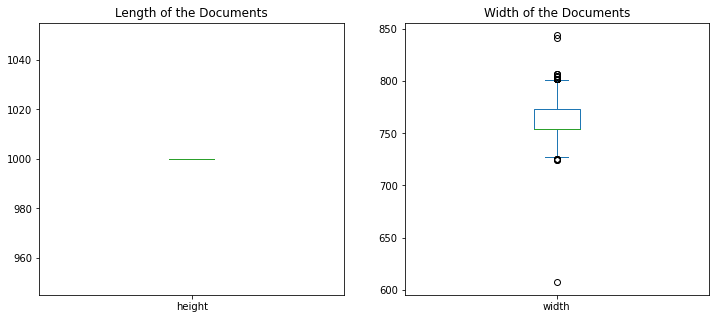

In [19]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
df['height'].plot(kind='box', ax=ax[0])
df['width'].plot(kind='box', ax=ax[1])
ax[0].set_title('Length of the Documents')
ax[1].set_title('Width of the Documents')

From the graph above, we can see that the image documents dataset have standard length of 1000 px and variative width ranging from 600 - 850 px.

### Read the Image and XML data
These code will see what kind of data provided under .xml format 


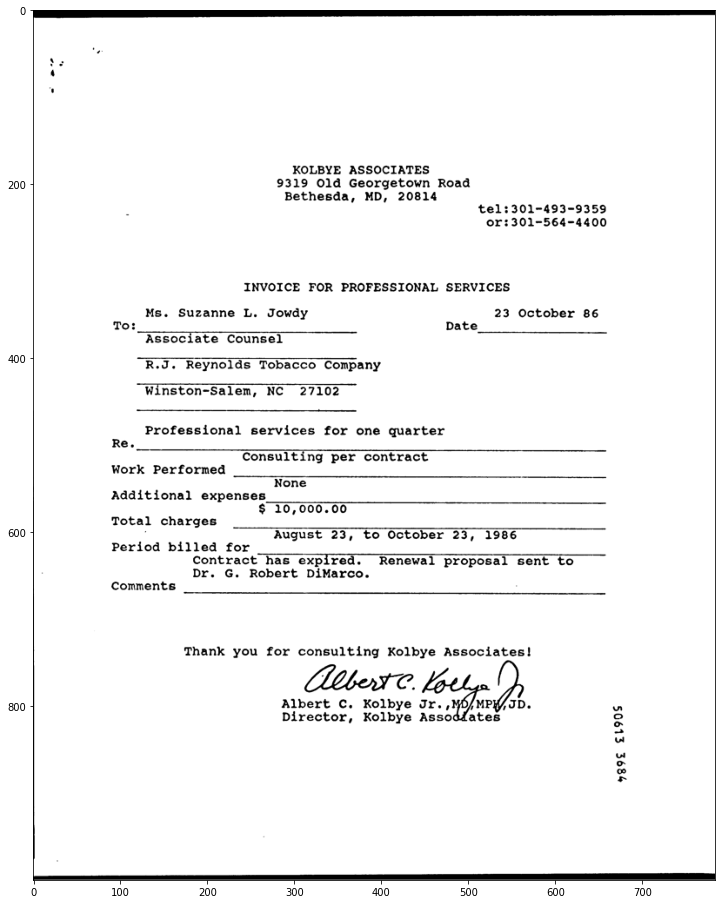

In [20]:
fn = '506133684.tif'
fn = filepath + fn
image = mpimg.imread(fn)
plt.imshow(image, cmap='gray')
f = plt.gcf()
f.set_size_inches(24.5, 16)
plt.show()

In [21]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

In [22]:
fn = '506133684_gt.xml'
fn = filepath + fn

with open(fn, 'r') as f:
  _gt = f.read()

gt_data = BeautifulSoup(_gt, 'xml')
print(gt_data.prettify())

<?xml version="1.0" encoding="utf-8"?>
<PcGts xmlns:="http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15" xmlns:ns2="http://searchink.com/xml/frankstahlapi/1.0">
 <Metadata>
  <Creator>
   system
  </Creator>
  <Created>
   2019-01-25T17:41:42.473+01:00
  </Created>
  <LastChange>
   2019-02-02T02:57:27Z
  </LastChange>
 </Metadata>
 <Property key="customer" value="actuallCustomerName"/>
 <Property key="offer"/>
 <Property key="uuid" value="9242e299-d76f-45ea-8bf3-a6fbbcc9aeab"/>
 <Property key="fileName" value="506133684.pdf"/>
 <Property key="type" value="digital"/>
 <Page imageFilename="506133684.tif" imageHeight="1000" imageWidth="784">
  <TextRegion id="page1_pos1">
   <Property key="entity" value="supplier"/>
   <Coords points="272.956,166.572 669.373,166.572 669.373,257.595 272.956,257.595"/>
  </TextRegion>
  <TextRegion id="page1_pos2">
   <Property key="entity" value="other"/>
   <Coords points="233.434,303.106 556.795,303.106 556.795,325.861 233.434,325.861"/>
 

In [23]:
fn = '506133684_ocr.xml'
fn = filepath + fn

with open(fn, 'r') as f:
  _ocr = f.read()

ocr_data = BeautifulSoup(_ocr, 'xml')
print(ocr_data.prettify())

<?xml version="1.0" encoding="utf-8"?>
<PcGts xmlns:="http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15">
 <Metadata>
  <Creator>
   ABBYY FineReader Engine 11 + alto2page.xslt 2018.11.09
  </Creator>
  <Created>
   2019-01-23T00:00:00
  </Created>
  <LastChange>
   2019-01-23T00:00:00
  </LastChange>
 </Metadata>
 <Page imageFilename="506133684.tif" imageHeight="1000" imageWidth="784">
  <TextRegion id="Page1_TopMargin">
   <Property key="Margin" value="Top"/>
   <Coords points="0,0 784,0 784,178 0,178"/>
  </TextRegion>
  <TextRegion id="Page1_LeftMargin">
   <Property key="Margin" value="Left"/>
   <Coords points="0,178 89,178 89,821 0,821"/>
  </TextRegion>
  <TextRegion id="Page1_RightMargin">
   <Property key="Margin" value="Right"/>
   <Coords points="660,178 784,178 784,1000 660,1000"/>
  </TextRegion>
  <TextRegion id="Page1_Block1">
   <Property key="language" value="en-US"/>
   <Coords points="666,799 683,799 683,888 666,888"/>
   <TextLine id="Page1_Block1_l1"

We can see that the XML file has pieces of information that we an parse using XML parser

## Preprocess the Data
Perform a preprocessing activities to prepare the image data. <br>
Source: [Pre-Processing in OCR!!!](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7)

In [25]:
import cv2

### Binarize
In layman’s terms **Binarization** means converting a coloured image into an image which consists of only black and white pixels (Black pixel value=0 and White pixel value=255). As a basic rule, this can be done by fixing a threshold (normally threshold=127, as it is exactly half of the pixel range 0–255). If the pixel value is greater than the threshold, it is considered as a white pixel, else considered as a black pixel.

Text(0.5, 1.0, 'Binarized Image')

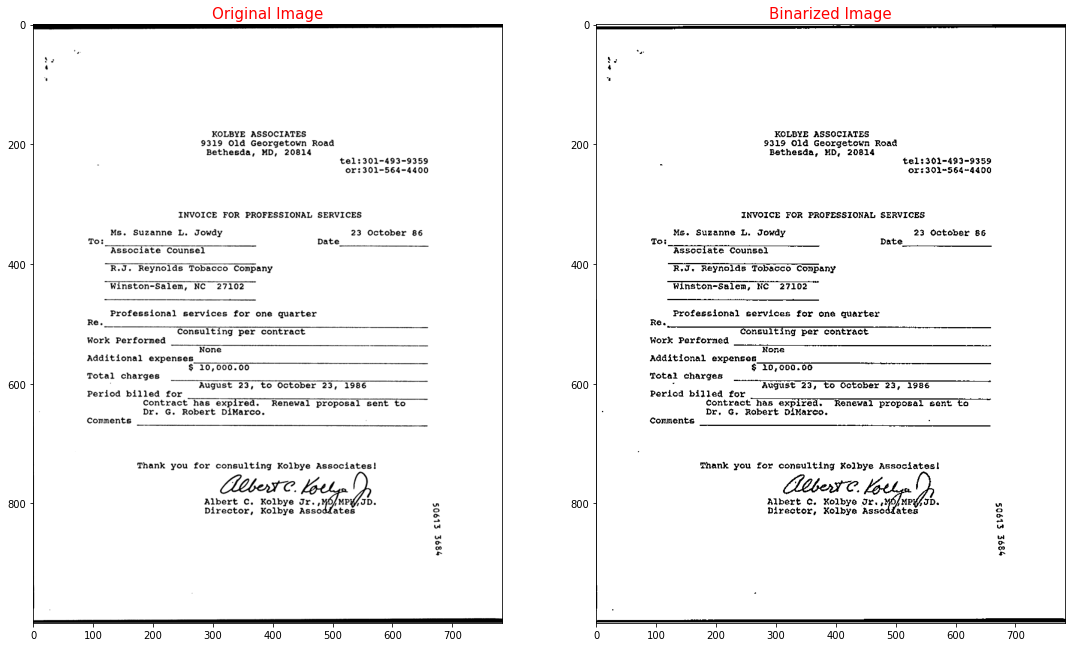

In [43]:
# binarize using adaptive threshold
fn1 = '506133684.tif'
fn1 = filepath + fn1

img1 = mpimg.imread(fn1)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

img1_binarize = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
ax[1].imshow(img1_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

Text(0.5, 1.0, 'Binarized Image')

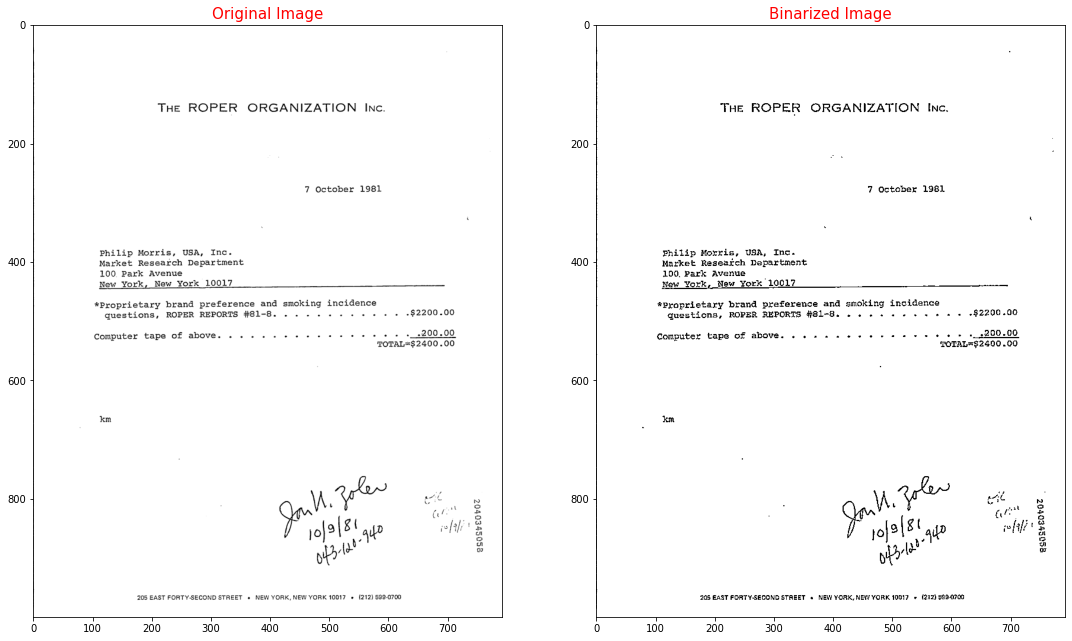

In [44]:
fn2 = '2040345058.tif'
fn2 = filepath + fn2

img2 = mpimg.imread(fn2)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img2, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

img2_binarize = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
ax[1].imshow(img2_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

### Skew Correction
While scanning a document, it might be slightly skewed (image aligned at a certain angle with horizontal) sometimes. While extracting the information from the scanned image, detecting & correcting the skew is crucial.


In [ ]:
# skew correction code